# 1. Imports

In [1]:
# Import libraries to verify installation
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import cv2
from PIL import Image
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.python.profiler import model_analyzer
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.data import AUTOTUNE
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")


2024-05-24 15:17:10.313218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 15:17:22.288578: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.4/lib64:/opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/
2024-05-24 15:17:22.288874: W tensorflow/compiler/xla/stream_exec

In [2]:
# Check whether Tensorflow has enabled GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1
TensorFlow version: 2.11.0


In [3]:
# Import the dataset
train_directory = './train'
test_directory = './test'
validation_directory = './valid'

train_img = [os.path.join(train_directory, f) for f in os.listdir(train_directory)]
test_img = [os.path.join(test_directory, f) for f in os.listdir(test_directory)]
valid_img = [os.path.join(validation_directory, f) for f in os.listdir(validation_directory)]

In [4]:
df_train = pd.read_csv("./birds.csv")
df_train.head()

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


# 2. Data Visualisation

We see that we have variying numbers of samples in the training set. In the test and validation sets, we have 5 samples each.

In [5]:
# Create an instance of ImageDataGenerator with desired augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Flow images from directory using the defined data generator
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224,224),
    batch_size=150,
    class_mode='categorical',
    color_mode='rgb')

Found 84635 images belonging to 525 classes.


In [6]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_directory,
                                                    target_size=(224,224),
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    color_mode='rgb')

Found 2625 images belonging to 525 classes.


In [7]:
val_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(validation_directory,
                                                target_size=(224,224),
                                                batch_size=150,
                                                class_mode='categorical',
                                                color_mode='rgb')

Found 2625 images belonging to 525 classes.


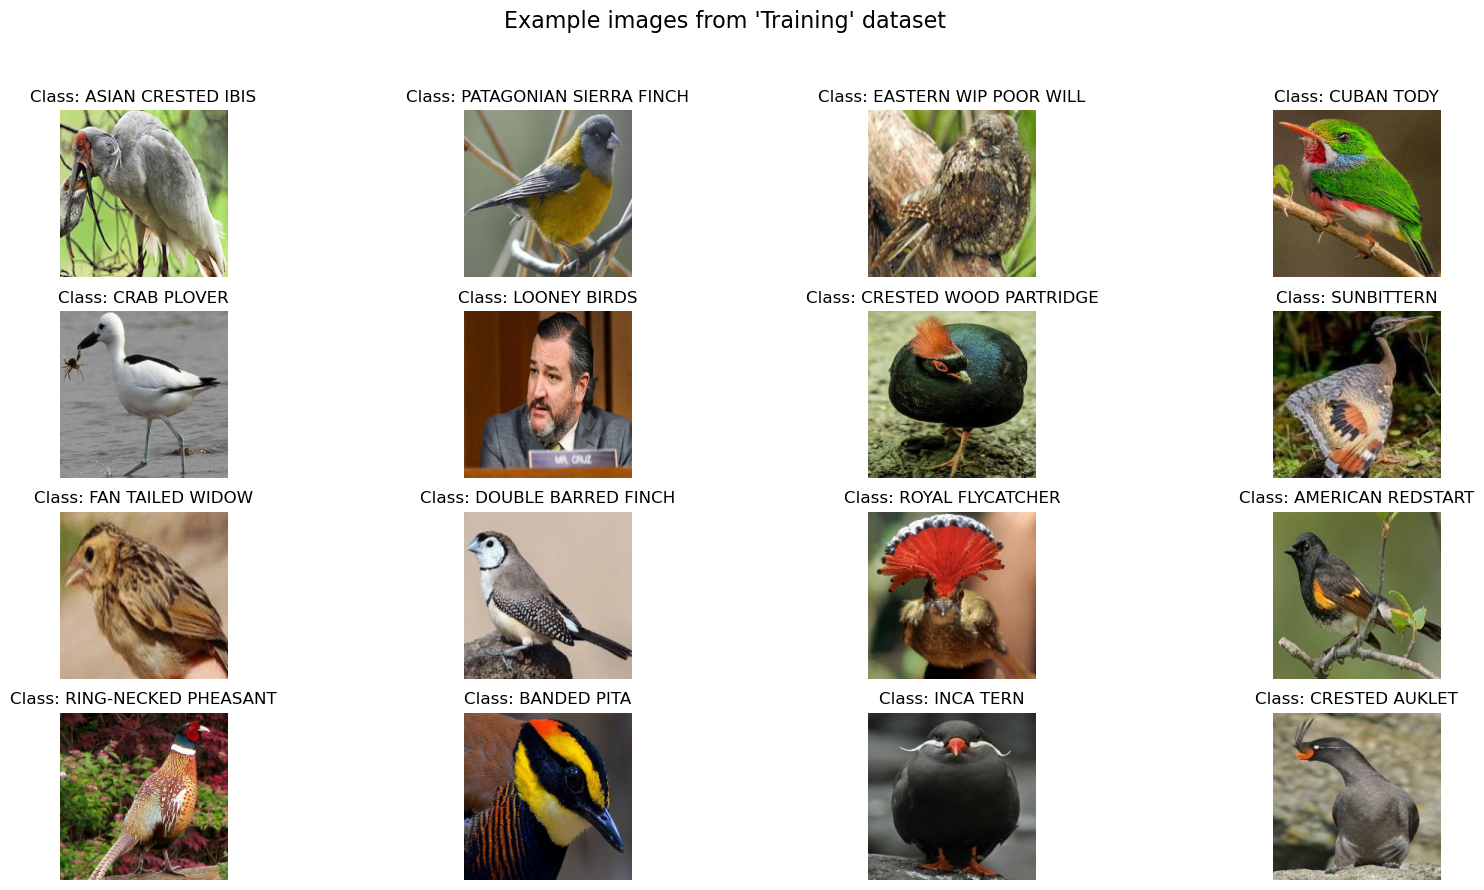

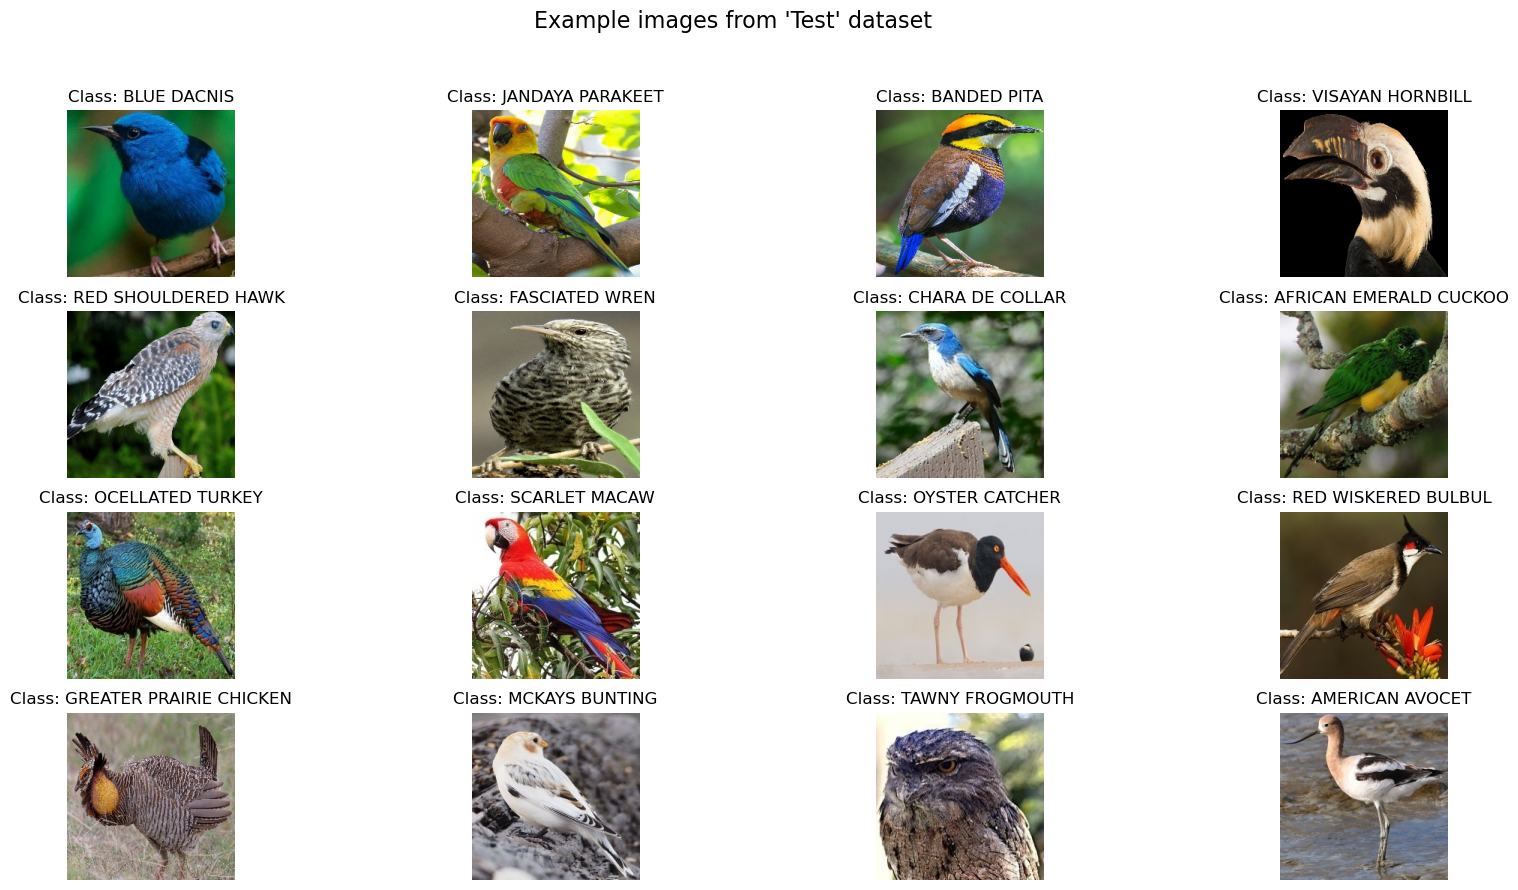

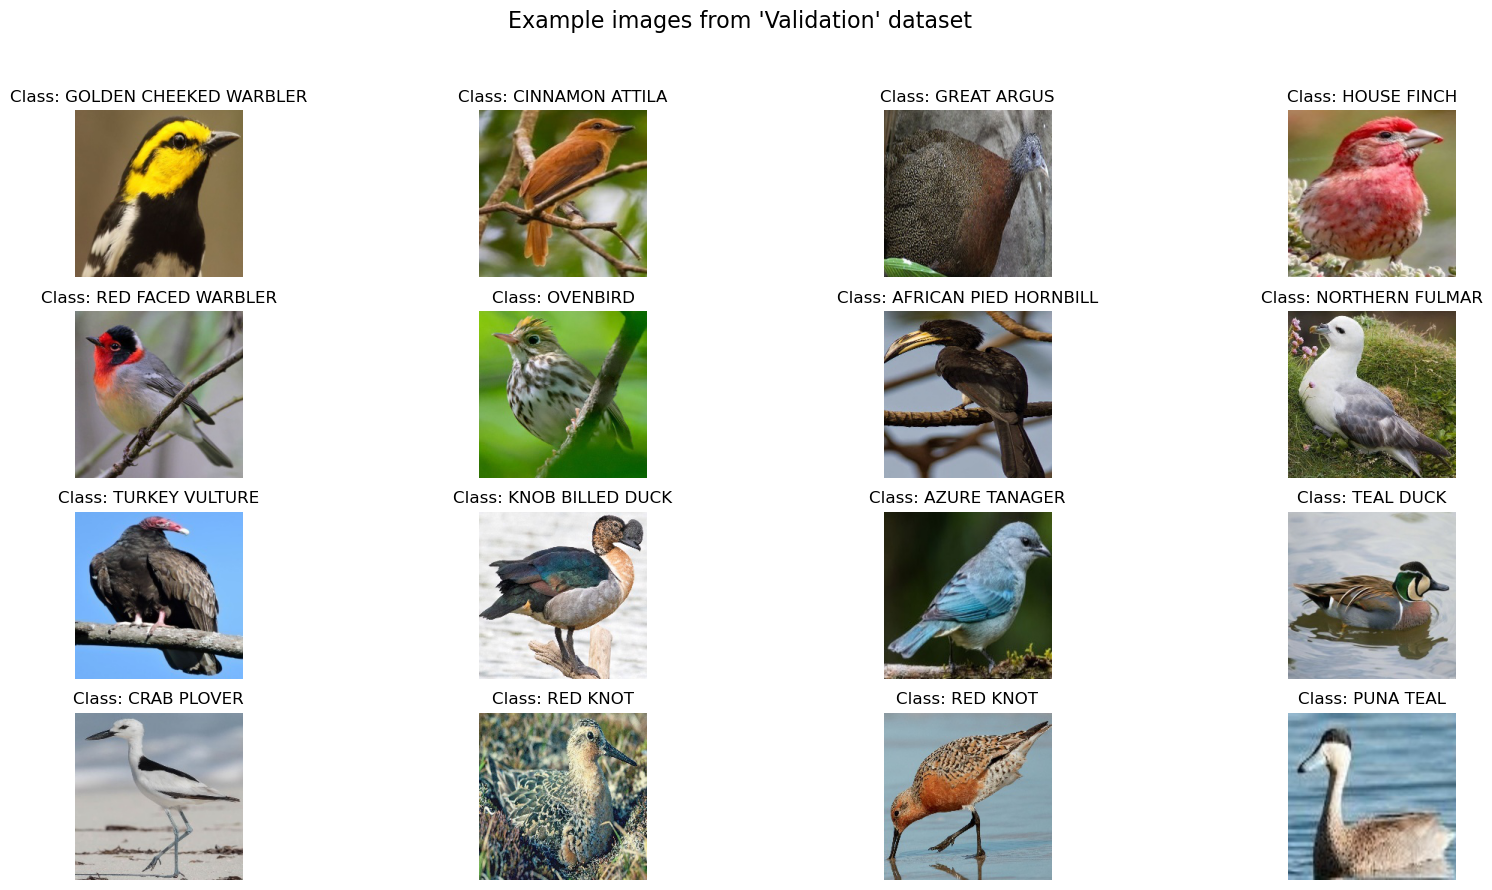

In [8]:
def visualize_data(data_directory, num_images, rows, class_names=None, dataset_name=None):
    plt.figure(figsize=(20, 10))
    if dataset_name:
        plt.suptitle(f"Example images from '{dataset_name}' dataset", fontsize=16)
    classes = os.listdir(data_directory)
    for i in range(num_images):
        # Randomly select a class (bird species)
        class_name = random.choice(classes)
        class_dir = os.path.join(data_directory, class_name)
        # Get a list of images in the class directory
        images = os.listdir(class_dir)
        # Randomly select an image from the class
        image_name = random.choice(images)
        image_path = os.path.join(class_dir, image_name)
        # Load and display the image
        image = Image.open(image_path)
        plt.subplot(rows, num_images // rows, i + 1)
        plt.imshow(image)
        plt.axis('off')
        if class_names is not None:
            plt.title(f"Class: {class_names[class_name]}")
        else:
            plt.title(f"Class: {class_name}")


# Define class names (if available)
class_names = {
    'class1': 'Species 1',
    'class2': 'Species 2',
    # Add more class mappings as needed
}

# Visualize the training data
visualize_data(train_directory, num_images=16, rows=4, dataset_name='Training')

# Visualize the test data
visualize_data(test_directory, num_images=16, rows=4, dataset_name='Test')

# Visualize the validation data
visualize_data(validation_directory, num_images=16, rows=4, dataset_name='Validation')



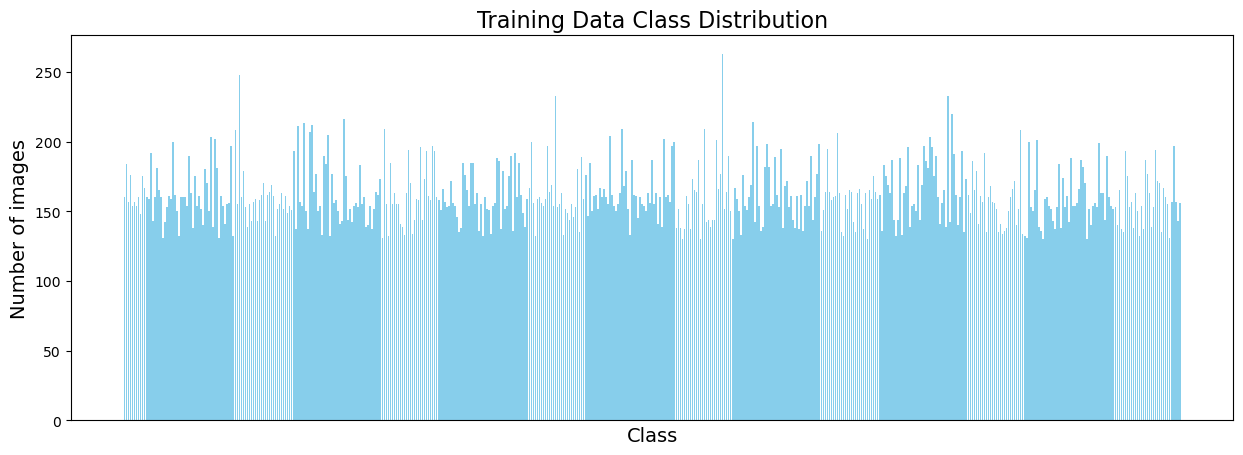

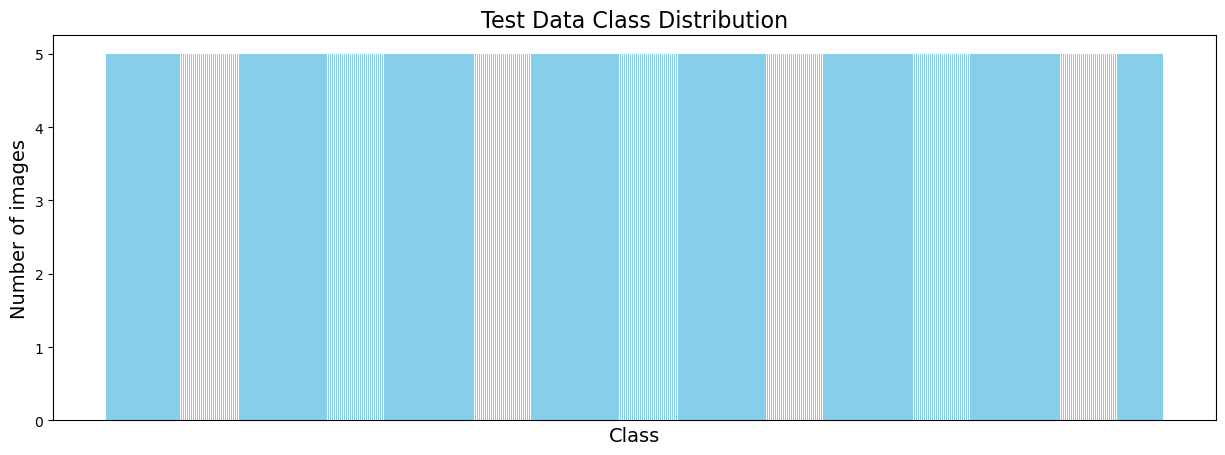

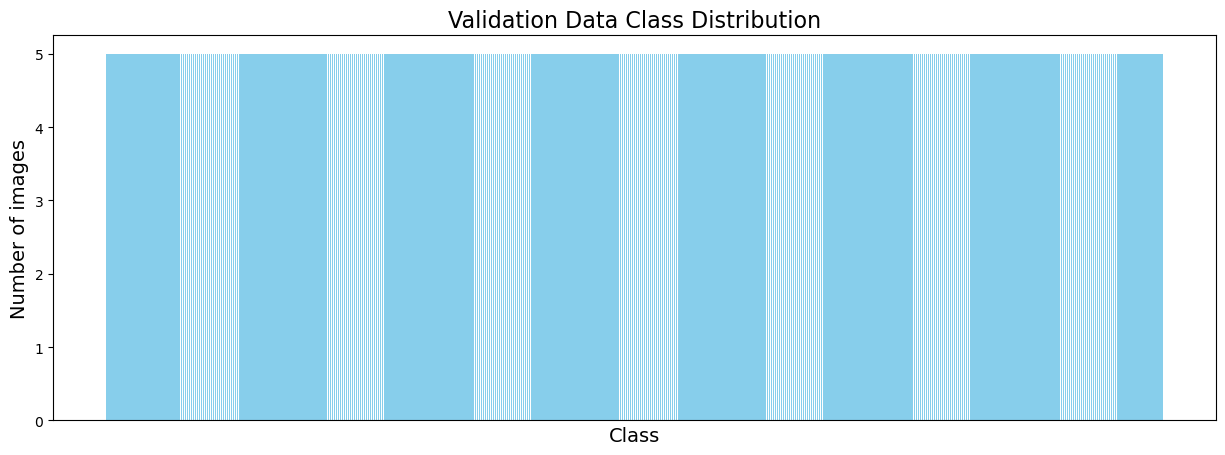

In [9]:
def plot_class_distribution(data_directory, title):
    # Filter out non-directory files (like .DS_Store)
    classes = [c for c in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, c))]
    num_images = [len(os.listdir(os.path.join(data_directory, c))) for c in classes]
    plt.figure(figsize=(15, 5))
    plt.bar(classes, num_images, color='skyblue')
    plt.title(title, fontsize=16)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Number of images', fontsize=14)
    plt.xticks([])
    plt.show()
# Plot the class distribution for the training data
plot_class_distribution(train_directory, title='Training Data Class Distribution')

# Plot the class distribution for the test data
plot_class_distribution(test_directory, title='Test Data Class Distribution')

# Plot the class distribution for the validation data
plot_class_distribution(validation_directory, title='Validation Data Class Distribution')


# 3. Model Selection & Training

### 3.1. CNN Model ResNet50

In [11]:
# Define image data generators with augmentation for training and only rescaling for validation and test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

# Adjust batch size based on GPU memory and performance
batch_size = 512  # Try larger batch size

# Load images from directories and apply transformations
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_val_datagen.flow_from_directory(
    validation_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Convert to tf.data.Dataset for efficient data pipeline
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([batch_size, 224, 224, 3], [batch_size, train_generator.num_classes])
).prefetch(AUTOTUNE)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: validation_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([batch_size, 224, 224, 3], [batch_size, validation_generator.num_classes])
).prefetch(AUTOTUNE)

# Load ResNet50 as the base model, pre-trained on ImageNet
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the base model to prevent weights from being updated during training
base_model.trainable = True
for layer in base_model.layers[:-15]:  # Keep the first N layers frozen
    layer.trainable = False

# Create a new model on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(525, activation='softmax')  # Output layer for 525 bird species
])

# Compile the model with mixed precision policy
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 525)               538125    
                                                                 
Total params: 26,224,013
Traina

In [ ]:
with tf.device('/GPU:0'):
    # Run your model training code
    model.fit(
        train_dataset,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=5,
        validation_data=validation_dataset,
        validation_steps=validation_generator.samples // batch_size
    )

timestamp = time.strftime("%Y%m%d-%H%M%S")
model.save(f'ResNet50_Sequential_v0_{timestamp}.h5')

### 3.2. Something else

In [20]:
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

model = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(525, activation='sigmoid')(x)

model = Model(inputs=model.input, outputs=predictions)

for layer in model.layers[:-5]:
    layer.trainable = False

model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,816,589 (18.37 MB)

 Trainable params: 1,589,773 (6.06 MB)

 Non-trainable params: 3,226,816 (12.31 MB)

### 3.3 Something 

In [21]:
# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_directory,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Get the number of classes
NUM_CLASSES = len(train_generator.class_indices)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Epoch 1/10
  31/2645 ━━━━━━━━━━━━━━━━━━━━ 36:06 829ms/step - accuracy: 0.0014 - loss: 6.3378

KeyboardInterrupt: 

In [45]:
import torch
from tqdm import tqdm

def move_to_device(module, device):
    if isinstance(module, torch.nn.Module):
        module.to(device)

def move_model_to_device(model, device):
    for module in model:
        move_to_device(module, device)

def train_setup(model, tr_dl, val_dl, epochs=10, device="cuda", patience=4, lr=3e-4):
    # Move the entire model to the device
    move_model_to_device(model, device)
    
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    
    best_val_loss = float('inf')
    best_val_acc = 0
    improvement = 0
    
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(epochs):
        epoch_loss, epoch_acc, total = 0, 0, 0

        # Training loop
        model.train()
        for idx, batch in tqdm(enumerate(tr_dl)):
            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)
            total += ims.shape[0]

            # Forward pass
            preds = model(ims)
            loss = loss_fn(preds, gts)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            _, pred_cls = torch.max(preds.data, dim=1)
            epoch_acc += (pred_cls == gts).sum().item()
            epoch_loss += loss.item()

        # Calculate average training loss and accuracy for the epoch
        tr_loss = epoch_loss / len(tr_dl)
        train_losses.append(tr_loss)
        train_accs.append(epoch_acc / total)

        print(f"Epoch {epoch + 1} train process is finished")
        print(f"Epoch {epoch + 1} train loss -> {tr_loss:.3f}")
        print(f"Epoch {epoch + 1} train accuracy -> {epoch_acc / total:.3f}")

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_epoch_loss, val_epoch_acc, val_total = 0, 0, 0
            for idx, batch in enumerate(val_dl):
                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device)
                val_total += ims.shape[0]

                # Forward pass
                preds = model(ims)
                loss = loss_fn(preds, gts)

                _, pred_cls = torch.max(preds.data, dim=1)
                val_epoch_acc += (pred_cls == gts).sum().item()
                val_epoch_loss += loss.item()

            # Calculate average validation loss and accuracy for the epoch
            val_loss = val_epoch_loss / len(val_dl)
            val_acc = val_epoch_acc / val_total
            val_losses.append(val_loss)
            val_accs.append(val_acc)

            print(f"Epoch {epoch + 1} validation is finished")
            print(f"Epoch {epoch + 1} validation loss -> {val_loss:.3f}")
            print(f"Epoch {epoch + 1} validation accuracy -> {val_acc:.3f}")

            # Save the model if the validation loss has improved
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_val_acc = val_acc
                improvement = 0
                torch.save(model.state_dict(), 'best_val.pth')
            else:
                improvement += 1
                if improvement >= patience:
                    print(f"No improvement in validation loss for {patience} epochs. Stopping early.")
                    break
    
    return model, train_losses, train_accs, val_losses, val_accs

# Usage example:
# model, train_losses, train_accs, val_losses, val_accs = train_setup(model, train_generator, validation_generator, epochs=10, device="cuda", patience=4, lr=3e-4)

model, train_losses, train_accs, val_losses, val_accs = train_setup(model, train_generator, validation_generator, epochs=10, device="cuda", patience=4, lr=3e-4)


TypeError: 'Sequential' object is not iterable